In [ ]:
!pip install transformers torch torchvision datasets accelerate albumentations opencv-python
!pip install evaluate matplotlib
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH = r"/content/drive/MyDrive/Documents/misis/cv/dataset"

Mounted at /content/drive


In [ ]:
import torch

print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

CUDA available: True
GPU: NVIDIA A100-SXM4-40GB


In [ ]:
import os
import torch
import json
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection import MeanAveragePrecision
from transformers import RTDetrImageProcessor, RTDetrForObjectDetection, Trainer, TrainingArguments
from transformers import RTDetrConfig
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
class YOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, processor, augment=False):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.processor = processor
        self.augment = augment

        self.image_files = [f for f in os.listdir(image_dir)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if augment:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.3),
                A.Blur(blur_limit=3, p=0.2),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
        else:
            self.transform = None

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_name)
        boxes = []
        class_labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    line = line.strip()
                    if line:
                        parts = line.split()
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])

                        boxes.append([x_center, y_center, width, height])
                        class_labels.append(class_id)

        if self.transform and len(boxes) > 0:
            image_np = np.array(image)
            transformed = self.transform(image=image_np, bboxes=boxes, class_labels=class_labels)
            image = Image.fromarray(transformed['image'])
            boxes = transformed['bboxes']
            class_labels = transformed['class_labels']

        img_width, img_height = image.size
        coco_boxes = []

        for box in boxes:
            x_center, y_center, width, height = box
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            x_min = x_center - width / 2
            y_min = y_center - height / 2

            coco_boxes.append([x_min, y_min, width, height])

        annotations = []
        for i, (box, class_label) in enumerate(zip(coco_boxes, class_labels)):
            x_min, y_min, width, height = box
            annotations.append({
                "id": i,
                "image_id": idx,
                "category_id": class_label,
                "bbox": [x_min, y_min, width, height],
                "area": width * height,
                "iscrowd": 0
            })

        target = {
            "image_id": idx,
            "annotations": annotations
        }

        encoding = self.processor(images=image, annotations=target, return_tensors="pt")

        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0] if "labels" in encoding else target

        return {
            "pixel_values": pixel_values,
            "labels": target
        }

In [ ]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    labels = [item["labels"] for item in batch]

    return {
        "pixel_values": torch.stack(pixel_values),
        "labels": labels
    }

def compute_metrics(eval_preds):
    try:
        predictions, labels = eval_preds
        preds = []
        targets = []

        for pred, target in zip(predictions, labels):
            if isinstance(pred, dict) and 'boxes' in pred:
                preds.append({
                    'boxes': pred['boxes'],
                    'scores': pred['scores'] if 'scores' in pred else torch.ones(pred['boxes'].shape[0]),
                    'labels': pred['labels'] if 'labels' in pred else torch.zeros(pred['boxes'].shape[0], dtype=torch.long)
                })

            if isinstance(target, dict) and 'boxes' in target:
                targets.append({
                    'boxes': target['boxes'],
                    'labels': target['class_labels'] if 'class_labels' in target else target.get('labels', torch.zeros(target['boxes'].shape[0], dtype=torch.long))
                })

        if preds and targets:
            map_metric = MeanAveragePrecision()
            map_result = map_metric(preds, targets)

            return {
                "map": map_result["map"].item(),
                "map_50": map_result["map_50"].item(),
                "map_75": map_result["map_75"].item(),
            }


def setup_training():
    BASE_DIR = PATH
    IMAGE_DIR_TRAIN = os.path.join(BASE_DIR, "imagenes", "train")
    LABEL_DIR_TRAIN = os.path.join(BASE_DIR, "etiquetas", "train")
    IMAGE_DIR_VAL = os.path.join(BASE_DIR, "imagenes", "test")
    LABEL_DIR_VAL = os.path.join(BASE_DIR, "etiquetas", "test")

    def count_classes(label_dir):
        classes = set()
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                with open(os.path.join(label_dir, label_file), 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = int(line.split()[0])
                            classes.add(class_id)
        return len(classes)

    num_classes = count_classes(LABEL_DIR_TRAIN)
    print(f"Detected {num_classes} classes in the dataset")

    processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_r50vd")

    model = RTDetrForObjectDetection.from_pretrained(
        "PekingU/rtdetr_r50vd",
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )

    train_dataset = YOLODataset(IMAGE_DIR_TRAIN, LABEL_DIR_TRAIN, processor, augment=True)
    val_dataset = YOLODataset(IMAGE_DIR_VAL, LABEL_DIR_VAL, processor, augment=False)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    training_args = TrainingArguments(
        output_dir="./rtdetr-finetuned",
        per_device_train_batch_size=16,  # in an A100 GPU
        per_device_eval_batch_size=16,
        num_train_epochs=50,
        learning_rate=1e-5,
        lr_scheduler_type="cosine",
        warmup_steps=500,
        weight_decay=1e-4,
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=3,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        push_to_hub=False,
        dataloader_num_workers=2,
        remove_unused_columns=False,
        report_to=[],
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
    )

    return trainer, processor, model


In [ ]:
def train_model():
    trainer, processor, model = setup_training()
    trainer.train()

    trainer.save_model("./rtdetr-final")
    processor.save_pretrained("./rtdetr-final")

    print("Training completed!")
    return trainer, processor, model

In [ ]:
trainer, processor, model = train_model()

Detected 5 classes in the dataset


preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.cl

Training samples: 1178
Validation samples: 372
Starting training...


Epoch,Training Loss,Validation Loss
1,355.504800,255.252060
2,314.496000,165.687454
3,160.866300,85.450958
4,104.214000,60.865002
5,70.047500,48.230816
6,58.919000,40.160900
7,46.763100,33.636646
8,41.729600,27.296741
9,33.720500,24.577805
10,30.910800,23.109438


There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

Training completed!


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def run_inference(model, processor, image_path, threshold=0.5):
    """Run inference on a single image"""
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=threshold
    )[0]

    return results

def visualize_predictions(image_path, results, class_names=None):
    image = Image.open(image_path).convert('RGB')
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = box.cpu().numpy()
        score = score.cpu().item()
        label = label.cpu().item()

        rect = patches.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1],
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        label_text = f"{class_names[label] if class_names else label}: {score:.2f}"
        ax.text(box[0], box[1] - 5, label_text,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
                fontsize=10, color='white')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

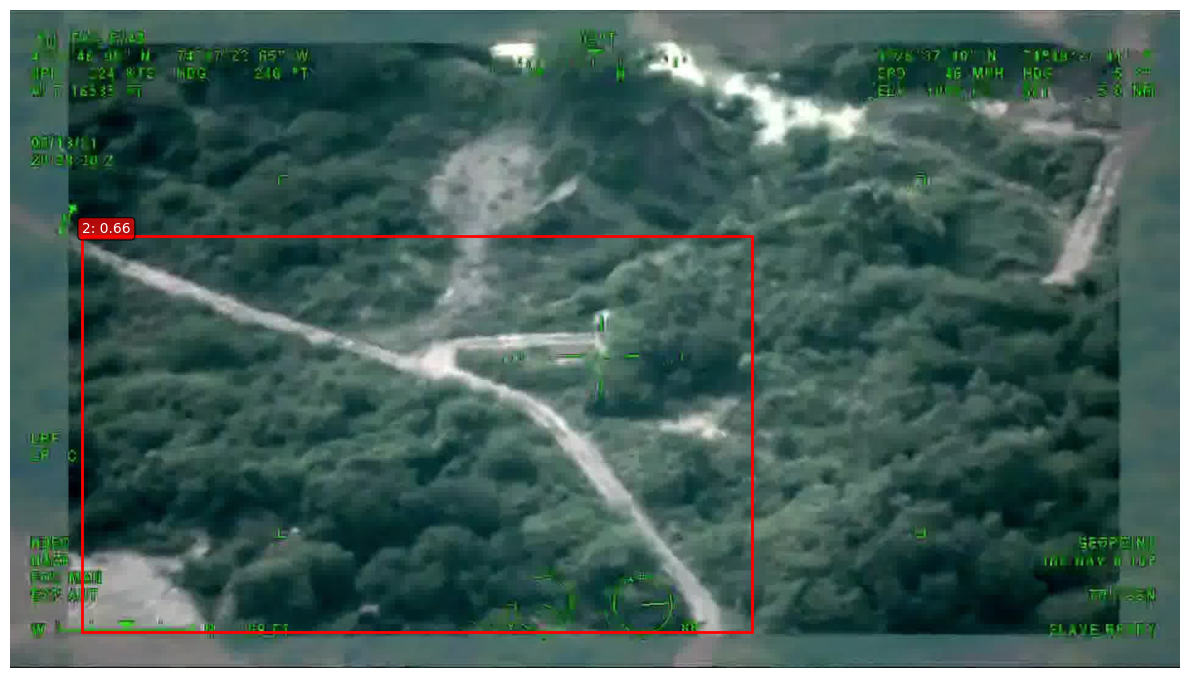

In [ ]:
test_path = '/content/drive/MyDrive/Documents/misis/cv/dataset/imagenes/test/video_11min_499.jpg'

results = run_inference(model, processor, test_path)
visualize_predictions(test_path, results)